In [1]:
import jax
import chex
import einops
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt

from io import StringIO
from functools import partial
from datetime import datetime

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 16

In [3]:
theta_values = -2, -1, 0, 3, 7,

## HMM Orstein-Uhlenbeck process

$$
    x_{t+\Delta}^\ell = \kappa(\theta_{t, \ell} - x_{t, \ell}) \Delta + \sigma\sqrt{\Delta} W_t
$$

with $W_t \sim \cal{N}(0, 1)$

In [4]:
transition_matrix = jnp.array([
    [0.00,  0.05, 0.05, 0.05, 0.05],
    [0.10,  00.0, 0.10, 0.05, 0.05],
    [0.10,  0.20, 0.00, 0.05, 0.05],
    [0.10,  0.20, 0.01, 0.00, 0.05],
    [0.10,  0.20, 0.20, 0.20, 0.00],
])

p_stay = 1 - transition_matrix.sum(axis=1)
transition_matrix = transition_matrix.at[jnp.diag_indices(5)].set(p_stay)

transition_matrix

Array([[0.8       , 0.05      , 0.05      , 0.05      , 0.05      ],
       [0.1       , 0.7       , 0.1       , 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.59999996, 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.01      , 0.64      , 0.05      ],
       [0.1       , 0.2       , 0.2       , 0.2       , 0.3       ]],      dtype=float32)

## Loading datset

In [7]:
url = """
https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=345427200&period2=1701993600&interval=1d&events=history&includeAdjustedClose=true
"""

In [5]:
date_init = datetime.timestamp(datetime(2000, 1, 1))
date_end = datetime.timestamp(datetime(2023, 12, 8))

config = {
    "events": "history",
    "period1": str(int(date_init)),
    "period2": str(int(date_end)),
    "includeAdjustedClose": "true"
}

In [6]:
assets = ["JPM", "AAPL", "SHEL", "WMT", "KO", "HD"]

In [7]:
datasets = {}
for asset in assets:
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{asset}"
    r = requests.get(
        url,
        headers={'User-agent': 'Mozilla/5.0'},
        params=config
    )

    data = pd.read_csv(StringIO(r.text))
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.set_index("Date")

    series = data["Adj Close"]
    series.name = asset
    datasets[asset] = series
datasets = pd.DataFrame.from_dict(datasets)

In [376]:
returns = np.log1p(datasets.pct_change(1)).dropna() # log(1 + x); x = (S1 / S0 - 1); log(1 + S1 / S0 - 1) = log(S1 / S0)
returns = jnp.array(returns.to_numpy())
n_steps, _ = returns.shape
timesteps = np.arange(n_steps)

In [377]:
# returns = jnp.c_[returns, jnp.zeros(n_steps)]
# assets = [*assets, "NULL"]

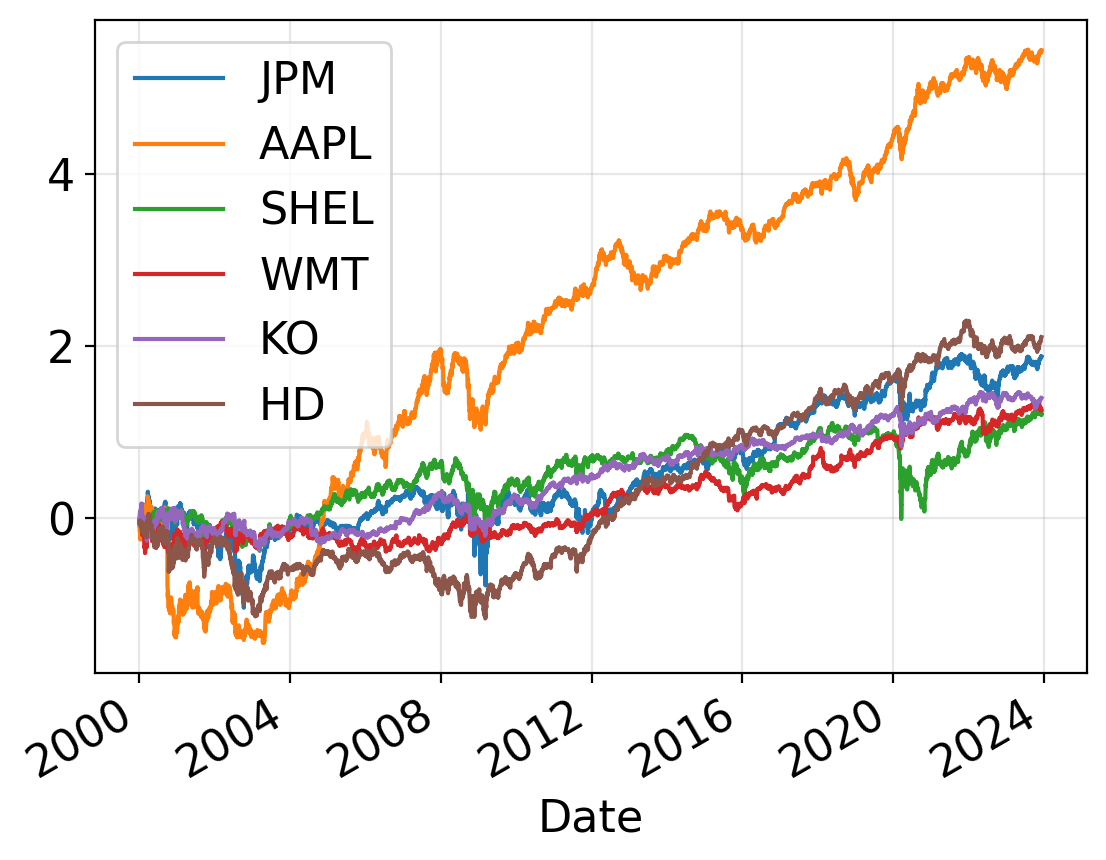

In [380]:
datasets_logr = pd.DataFrame(np.array(returns), index=datasets.index[1:], columns=assets)
(datasets_logr.cumsum()).plot()
plt.grid(alpha=0.3)
plt.savefig("../figures/rl-bandits-log-cumreturn.pdf")

In [381]:
n_bandits = len(assets)
count_v = jnp.zeros(n_bandits)
value_v = jnp.zeros(n_bandits)

In [382]:
@chex.dataclass
class BanditState:
    count: jax.Array
    value: jax.Array
    key: jax.random.PRNGKey
        
    
@chex.dataclass
class BanditEWMState:
    value: jax.Array
    key: jax.random.PRNGKey

In [383]:
def epsilon_step(state, returns, epsilon):
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon) # w.r.t. the value function
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]
    new_count = state.count[action] + 1
    new_value = state.value[action] + (reward - state.value[action]) / new_count
    
    state = state.replace(
        value=state.value.at[action].set(new_value),
        count=state.count.at[action].set(new_count),
        key=jax.random.fold_in(state.key, new_count) # update random key
    )
    return state, reward

In [231]:
key = jax.random.PRNGKey(3141)
state = BanditState(count=count_v, value=value_v, key=key)
state_final, returns_bandit = jax.lax.scan(partial(epsilon_step, epsilon=0.1), state, returns)

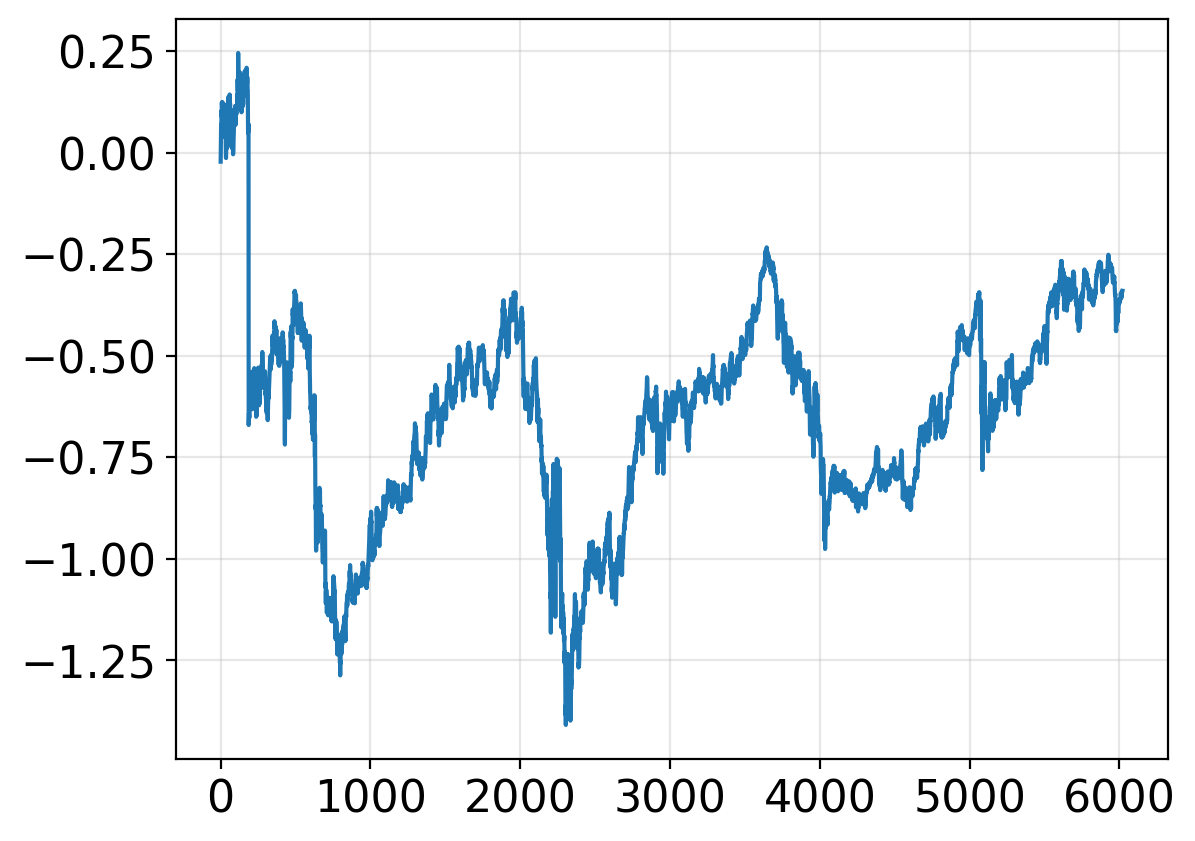

In [232]:
plt.plot(returns_bandit.cumsum())
plt.grid(alpha=0.3)

In [234]:
@partial(jax.vmap, in_axes=(None, None, 0), out_axes=1)
def returns_bandit(key, data, epsilon):
    _, n_arms = data.shape
    count_v = jnp.zeros(n_arms)
    value_v = jnp.zeros(n_arms)
    state = BanditState(count=count_v, value=value_v, key=key)
    
    _, returns_bandit = jax.lax.scan(partial(epsilon_step, epsilon=epsilon), state, data)
    return returns_bandit

In [235]:
n_simulations = 100
epsilon_values = jnp.linspace(1e-7, 1, 25)

In [236]:
%%time
keys = jax.random.split(key, n_simulations)
epsilon_greedy_cumsum = jax.vmap(returns_bandit, in_axes=(0, None, None))(keys, returns, epsilon_values)
epsilon_greedy_cumsum = np.array(epsilon_greedy_cumsum)
epsilon_greedy_cumsum = epsilon_greedy_cumsum.cumsum(axis=1)

CPU times: user 2.33 s, sys: 152 ms, total: 2.48 s
Wall time: 11.1 s


In [237]:
epsilon_greedy_final = epsilon_greedy_cumsum[:, -1, :]
epsilon_greedy_final = pd.DataFrame(
    epsilon_greedy_final, columns=epsilon_values
)

In [238]:
median_value_final = epsilon_greedy_final.median(axis=0)

summary_final = epsilon_greedy_final.melt()
summary_final.head()

,variable,value
0,1.000000e-07,1.008006
1,1.000000e-07,1.008006
2,1.000000e-07,1.008006
3,1.000000e-07,1.008006
4,1.000000e-07,1.008006


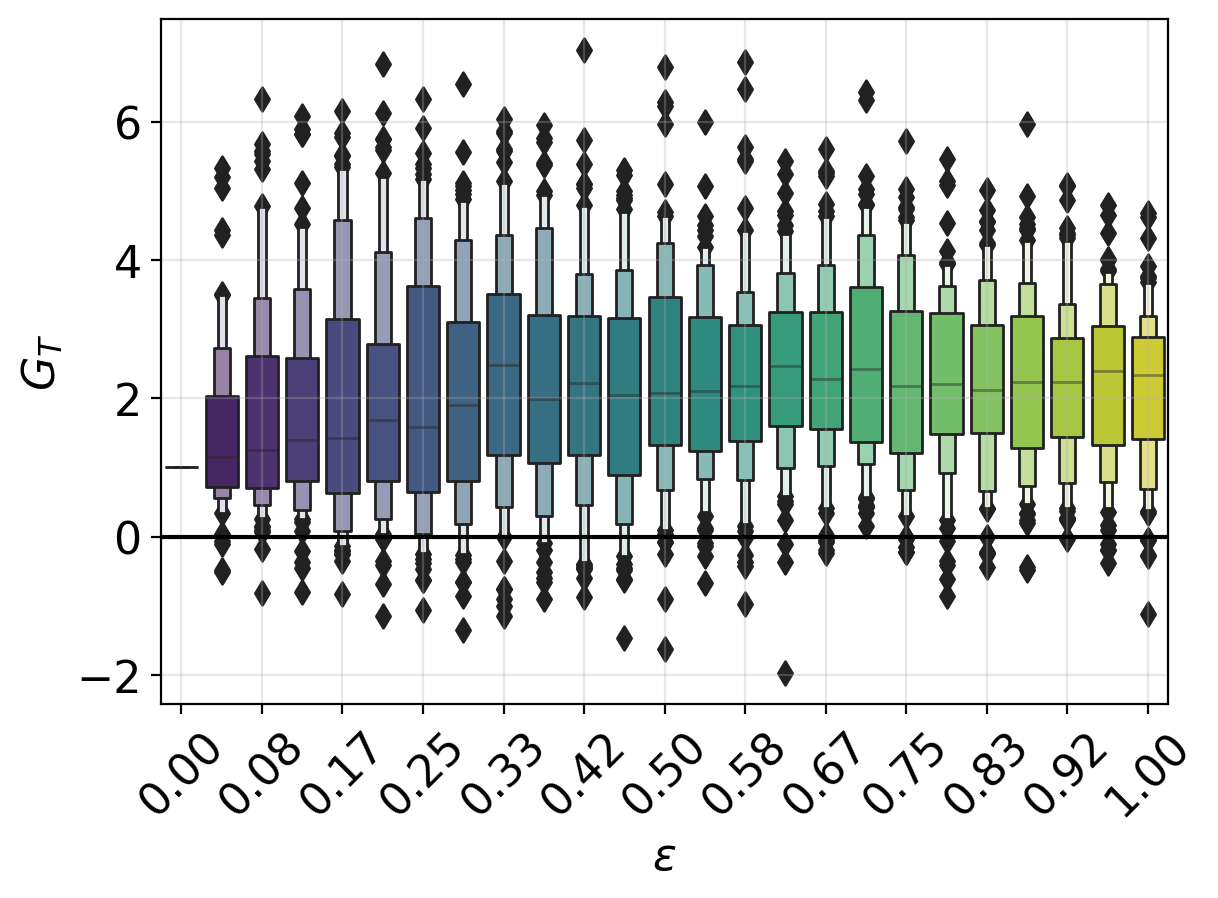

In [240]:
# NOTE: PRETTYFY with median_value_final

fig, ax = plt.subplots()
sns.boxenplot(
    y="value", x="variable", data=summary_final,
    palette="viridis", linewidth=1, ax=ax#, hue="variable"
)
plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("$G_T$")
plt.tight_layout()
plt.axhline(y=0, c="black")
plt.savefig("stationary-bandit-mean.pdf")

0.50000006


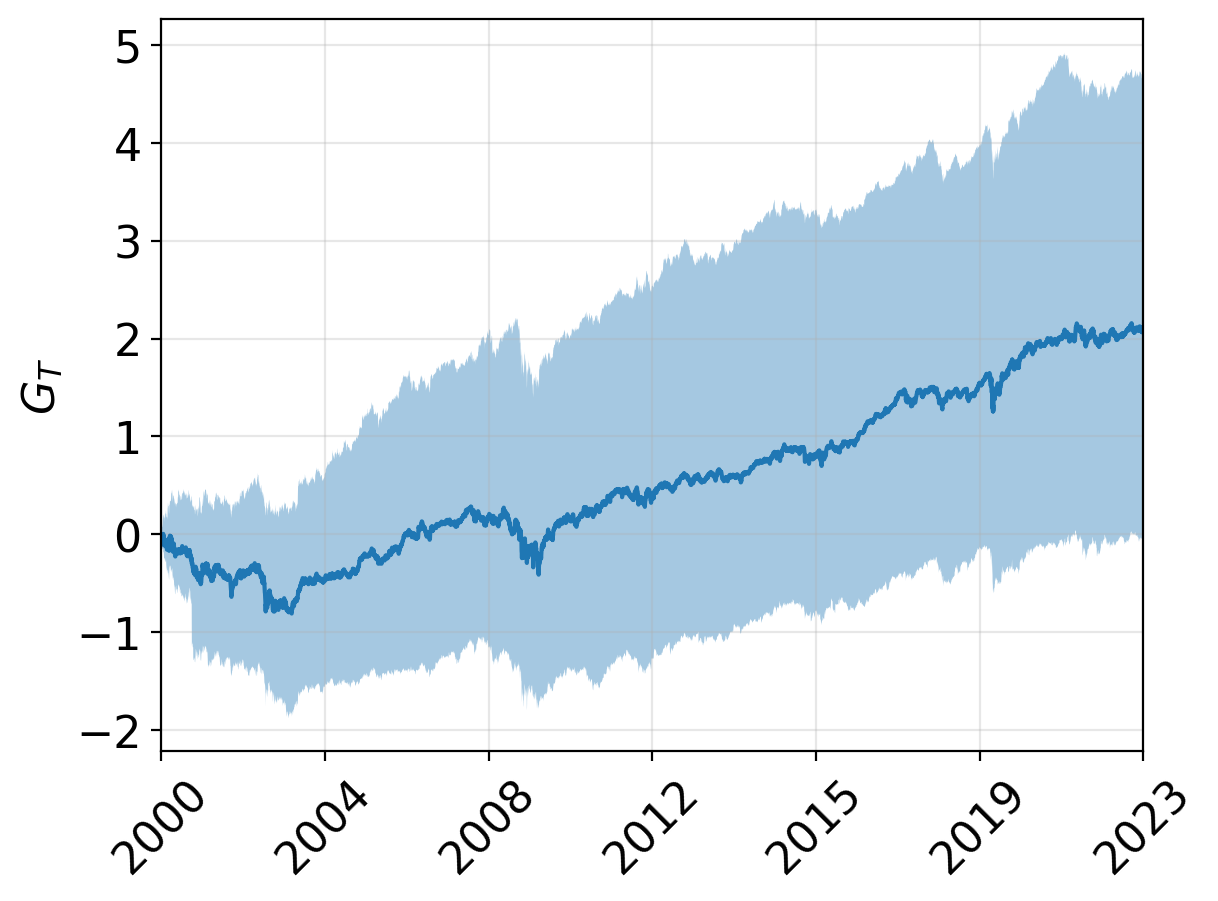

In [241]:
ix = 12
print(epsilon_values[ix])
plt.plot(
    np.percentile(epsilon_greedy_cumsum[:, :, ix], 50, axis=0)
)

lbound = np.percentile(epsilon_greedy_cumsum[:, :, ix], 5, axis=0)
ubound = np.percentile(epsilon_greedy_cumsum[:, :, ix], 95, axis=0)

plt.fill_between(timesteps, lbound, ubound, alpha=0.4)
plt.grid(alpha=0.3)
vals, _ = plt.xticks()
ticks = vals / 6000 * 23 + 2000
plt.xticks(vals, ticks.round().astype(int), rotation=45)
plt.ylabel("$G_T$")
plt.xlim(0, 6000)
plt.tight_layout()
plt.savefig("../figures/rl-cumulative-reward-stationary-epsilon-greedy.pdf")

## Non-stationary version

In [ ]:
def epsilon_ewm_step(state, returns, epsilon, alpha):
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon)
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]

    new_value = state.value[action] + alpha * (reward - state.value[action])
    
    state = state.replace(
        value=state.value.at[action].set(new_value),
        key=jax.random.split(state.key)[1]
    )
    
    return state, (reward, action)

In [303]:
def epsilon_ewm_step(state, returns, epsilon, alpha):
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon)
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]

    new_value = state.value[action] + alpha * (reward - state.value[action])
    
    state = state.replace(
        value=state.value.at[action].set(new_value),
        key=jax.random.split(state.key)[1]
    )
    
    return state, (reward, action, state.value)

In [304]:
def returns_bandit(key, data, alpha, epsilon):
    _, n_arms = data.shape
    count_v = jnp.zeros(n_arms)
    value_v = jnp.zeros(n_arms)
    state = BanditEWMState(value=value_v, key=key)
    
    _, returns_bandit = jax.lax.scan(partial(epsilon_ewm_step, epsilon=epsilon, alpha=alpha), state, data)
    return returns_bandit

In [305]:
@partial(jax.jit, static_argnames=("n_sims",))
def returns_bandit_sims(key, data, alpha, epsilon, n_sims):
    keys = jax.random.split(key, n_sims)
    vmap_returns = jax.vmap(returns_bandit, in_axes=(0, None, None, None))
    
    returns = vmap_returns(keys, data, alpha, epsilon)
    return returns

In [354]:
(sims, actions, value_hist) = returns_bandit_sims(key, returns, alpha=0.8, epsilon=0.25, n_sims=50)
(sims, actions, value_hist) = returns_bandit_sims(key, returns, alpha=0.5, epsilon=0.82, n_sims=50)
final_reward = sims.sum(axis=1)
final_reward

Array([ 1.247139  ,  1.4394113 ,  3.464014  ,  0.05898389,  0.74581736,
       -0.2433081 ,  1.7037663 ,  3.1701586 ,  2.2936358 ,  3.6927764 ,
       -0.04158992,  1.880366  ,  1.7203257 ,  3.8087997 ,  2.829131  ,
        1.0873793 ,  2.220501  ,  2.8218853 ,  2.2569337 ,  2.4851205 ,
        1.6014202 ,  1.6029887 ,  2.332343  ,  3.6985784 ,  2.0882463 ,
        2.9144278 ,  3.8921876 ,  3.709687  ,  0.9862263 ,  2.0781908 ,
        4.600968  ,  4.1198263 ,  1.5822276 ,  3.9475744 ,  3.6726527 ,
        2.1314301 ,  2.3141494 ,  3.4770365 ,  3.3290067 ,  0.7888096 ,
        2.5388522 ,  1.5976905 ,  0.6300831 ,  2.8157141 ,  2.2050734 ,
        0.79668844,  5.64167   ,  1.1034646 ,  2.2083228 ,  0.4454291 ],      dtype=float32)

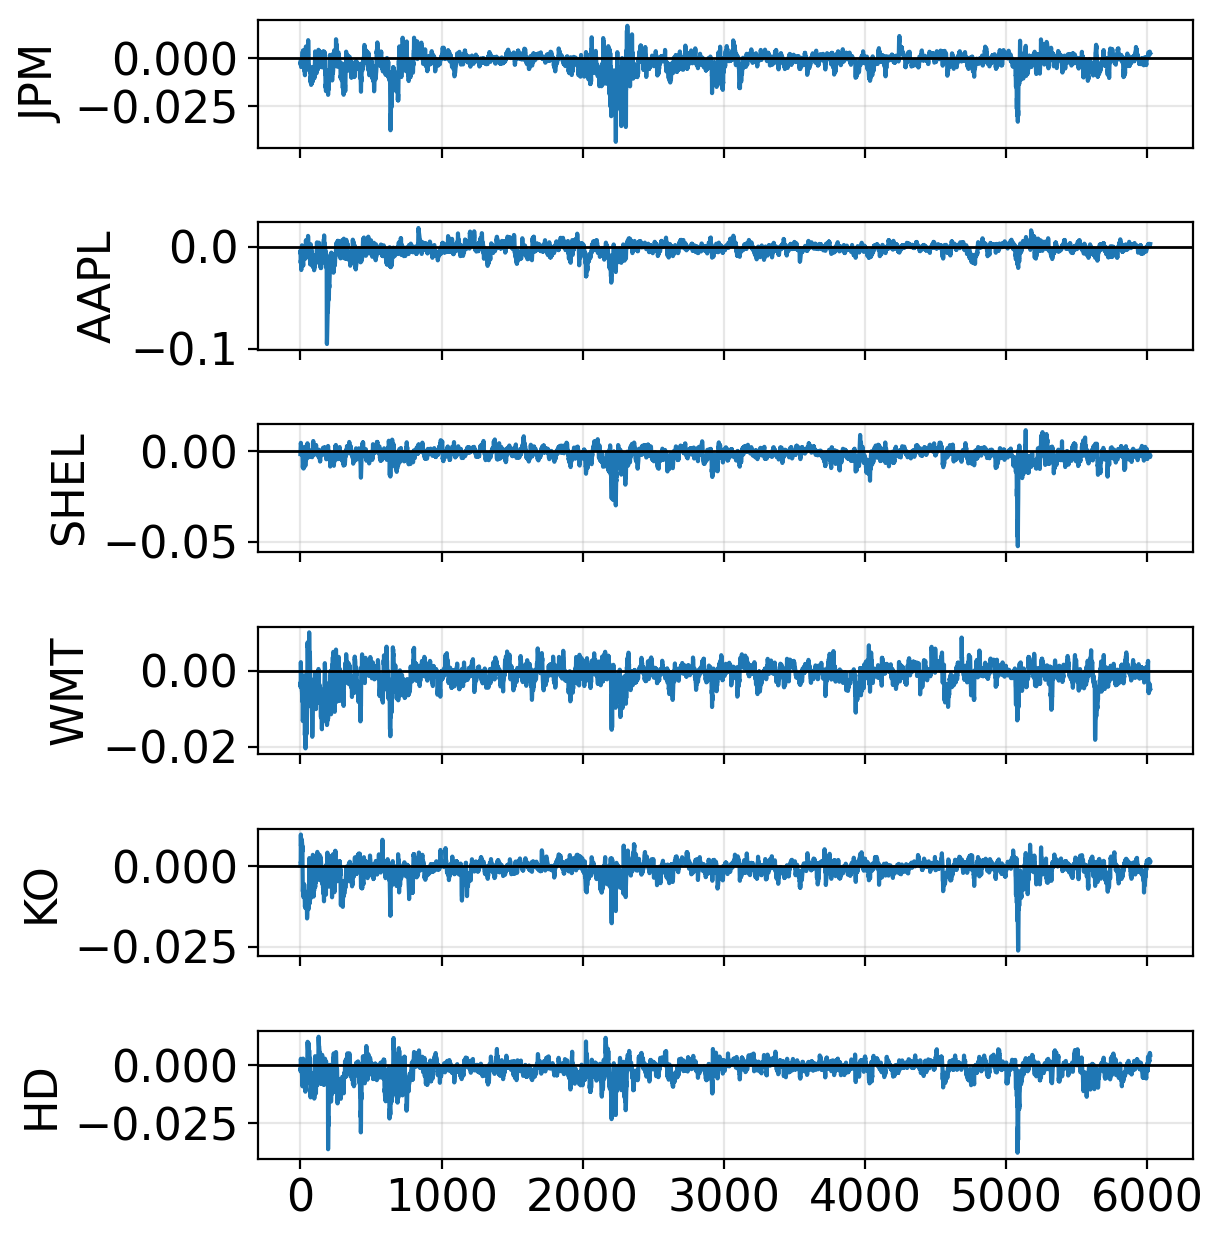

In [358]:
fig, ax = plt.subplots(len(assets), 1, figsize=(6.4, 6.5), sharex=True)
for i, axi in enumerate(ax):
    axi.plot(value_hist[..., i].mean(axis=0))
    axi.grid(alpha=0.3)
    axi.set_ylabel(assets[i])
    axi.axhline(y=0, c="black", linewidth=1)
plt.tight_layout()

In [359]:
np.bincount(np.percentile(actions, 50, axis=0).astype(int))

array([   0,  117, 3523, 2345,   36])

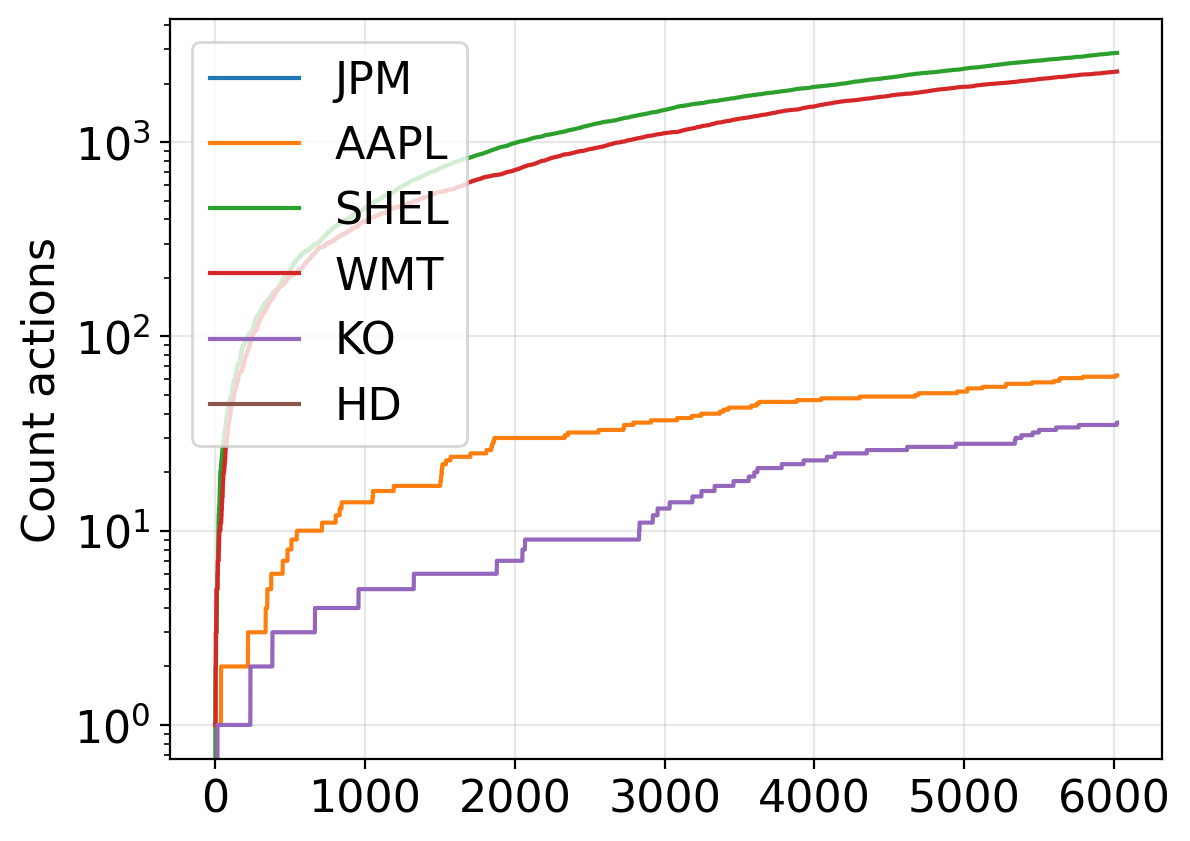

In [360]:
actions_sum = np.array(jax.nn.one_hot(jnp.percentile(actions, 50, axis=0), len(assets)))
plt.plot(actions_sum.cumsum(axis=0), label=assets)
plt.legend()
plt.ylabel("Count actions")
plt.yscale("log")
plt.grid(alpha=0.3)

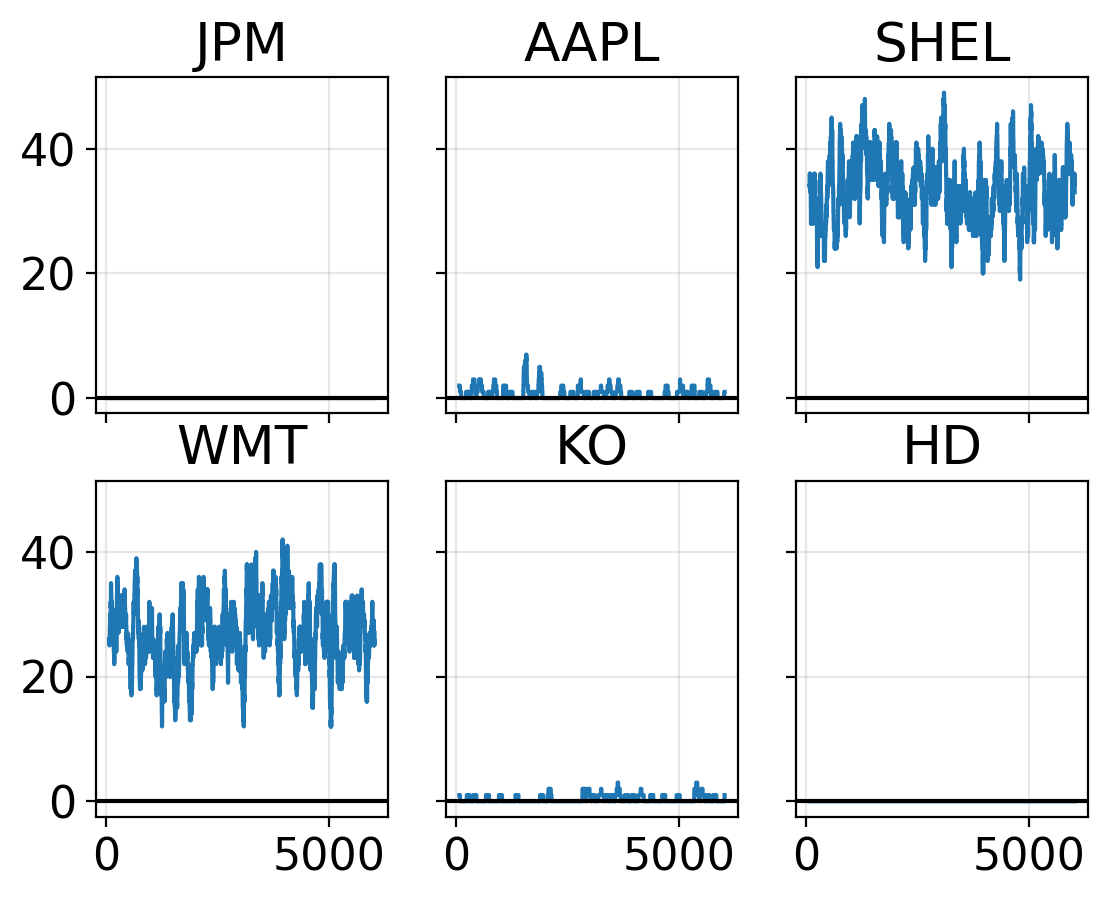

In [361]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
ax = ax.ravel()
v = pd.DataFrame(actions_sum).rolling(280 // 4).sum()
for i, axi in enumerate(ax):
    axi.set_title(assets_plus[i])
    axi.plot(v[i])
    axi.axhline(y=0, c="black")
    axi.grid(alpha=0.3)

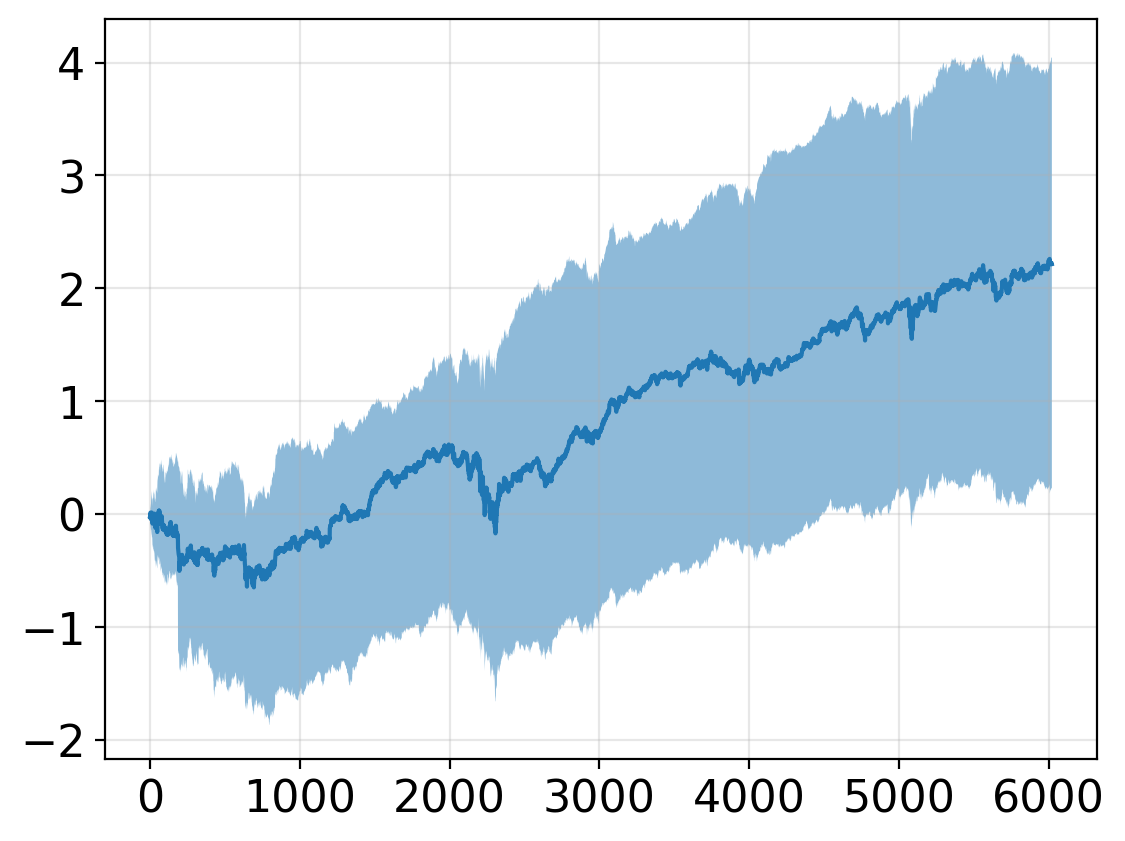

In [362]:
returns_cumsum = sims.cumsum(axis=1)
midval = jnp.percentile(returns_cumsum, q=50, axis=0)
lbound = jnp.percentile(returns_cumsum, q=5, axis=0)
ubound = jnp.percentile(returns_cumsum, q=95, axis=0)

plt.plot(midval)
plt.fill_between(timesteps, ubound, lbound, alpha=0.5)
plt.grid(alpha=0.3)

In [365]:
@partial(jax.vmap, in_axes=(None, None, 0, None, None))
@partial(jax.vmap, in_axes=(None, None, None, 0, None))
def xfinal_reward_bandit(key, data, alpha, epsilon, n_sims):
    (rewards, _, _) = returns_bandit_sims(key, data, alpha, epsilon, n_sims)
    return rewards.sum(axis=1)

In [366]:
%%time
n_simulations = 50
alpha_values = jnp.linspace(0.01, 1, 15)
epsilon_values = jnp.linspace(0.01, 1, 25)

xfinal_reward = xfinal_reward_bandit(key, returns, alpha_values, epsilon_values, n_simulations).mean(axis=-1)
xfinal_reward = pd.DataFrame(np.array(xfinal_reward), index=alpha_values, columns=epsilon_values)

CPU times: user 83.5 ms, sys: 25.7 ms, total: 109 ms
Wall time: 55.4 s


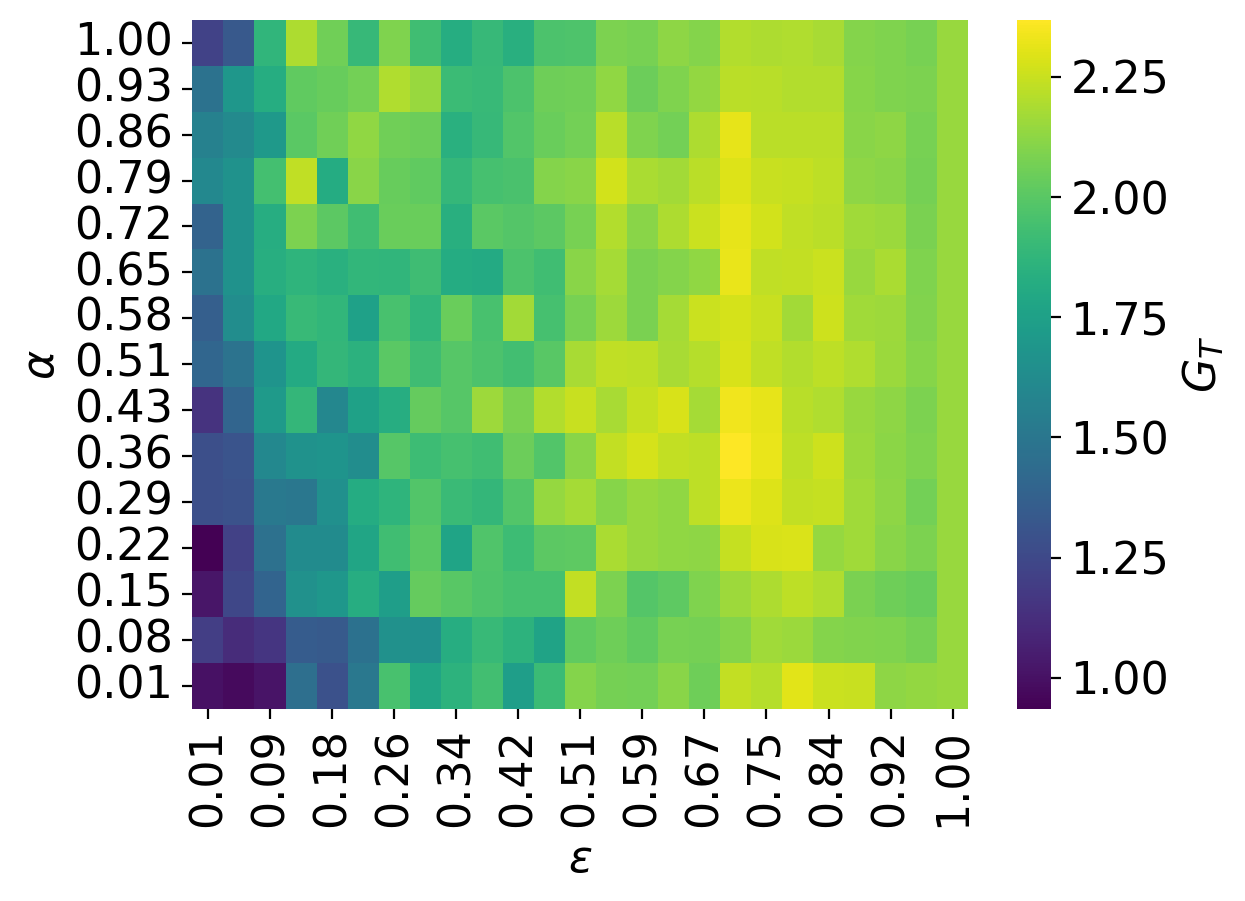

In [367]:
ax = sns.heatmap(
   xfinal_reward,
    # annot=True,
    # xticklabels=10,
    # yticklabels=10,
    cmap="viridis",
    cbar_kws={"label": "$G_T$"}
)
ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])
ax.set_xticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_xticklabels()])
ax.invert_yaxis()

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\alpha$")
plt.tight_layout()
# plt.savefig("rl-bandits-epsilon-rewards-grid.png", dpi=300);

## Contextual bandits

In [281]:
context = (returns > 0) * 1
context.shape

(6021, 6)

In [282]:
def contextual_epsilon_ewm_step(state, xs, epsilon, alpha):
    returns, context = xs
    context = tuple(context)
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon)
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value[context].argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]

    update_ix = tuple((*context, action))
    new_value = state.value[update_ix] + alpha * (reward - state.value[update_ix])
    
    state = state.replace(
        value=state.value.at[update_ix].set(new_value),
        key=jax.random.split(state.key)[1]
    )
    
    return state, (reward, action)

In [283]:
def returns_bandit(key, rewards, context, alpha, epsilon):
    _, n_arms = data.shape
    shape = (*(2,) * n_arms, n_arms)
    value_v = jnp.zeros(shape)
    state = BanditEWMState(value=value_v, key=key)
    
    xs = (rewards, context)
    state_final, (returns_bandit, actions) = jax.lax.scan(partial(contextual_epsilon_ewm_step, epsilon=epsilon, alpha=alpha), state, xs)
    return returns_bandit, actions

In [284]:
res, actions = returns_bandit(key, returns[1:], context[:-1], alpha=0.5, epsilon=0.75)
actions_ohe = jax.nn.one_hot(actions, len(assets))

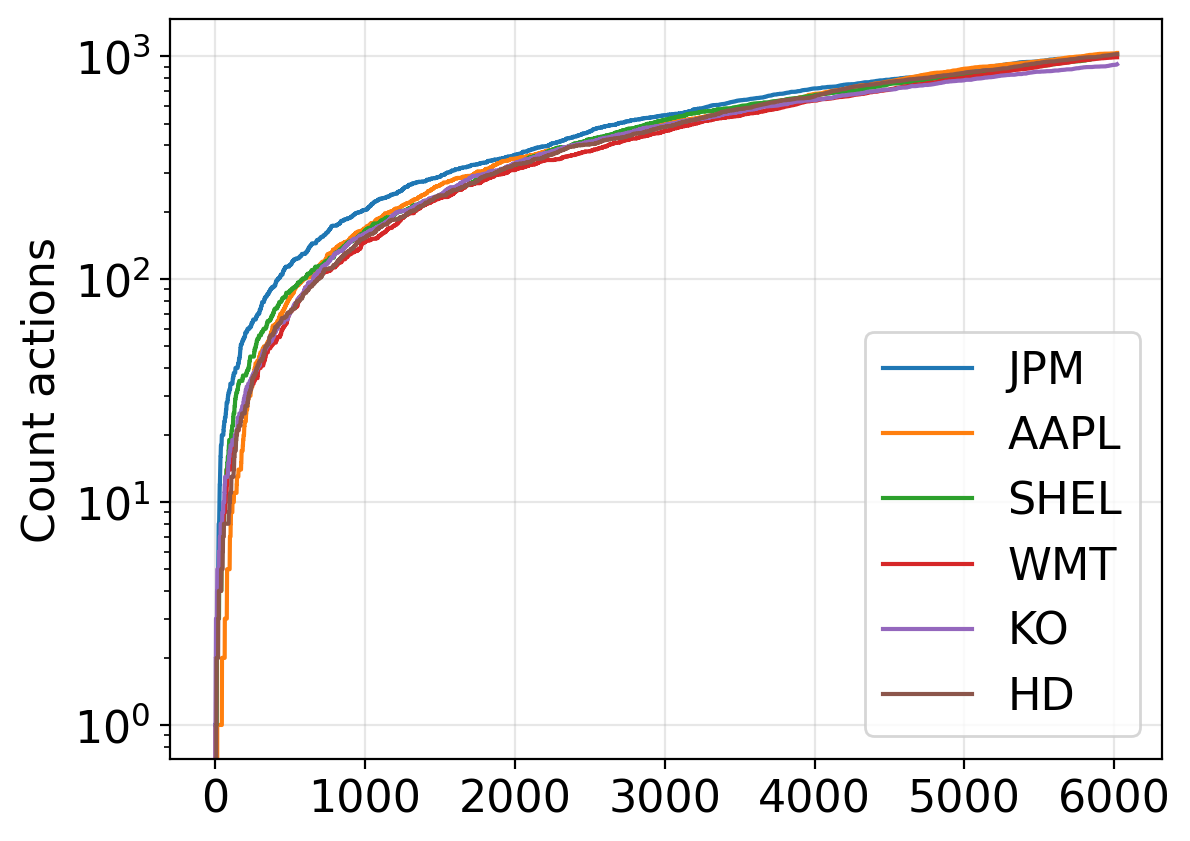

In [285]:
plt.plot(actions_ohe.cumsum(axis=0), label=assets)
plt.legend()
plt.ylabel("Count actions")
plt.yscale("log")
plt.grid(alpha=0.3)

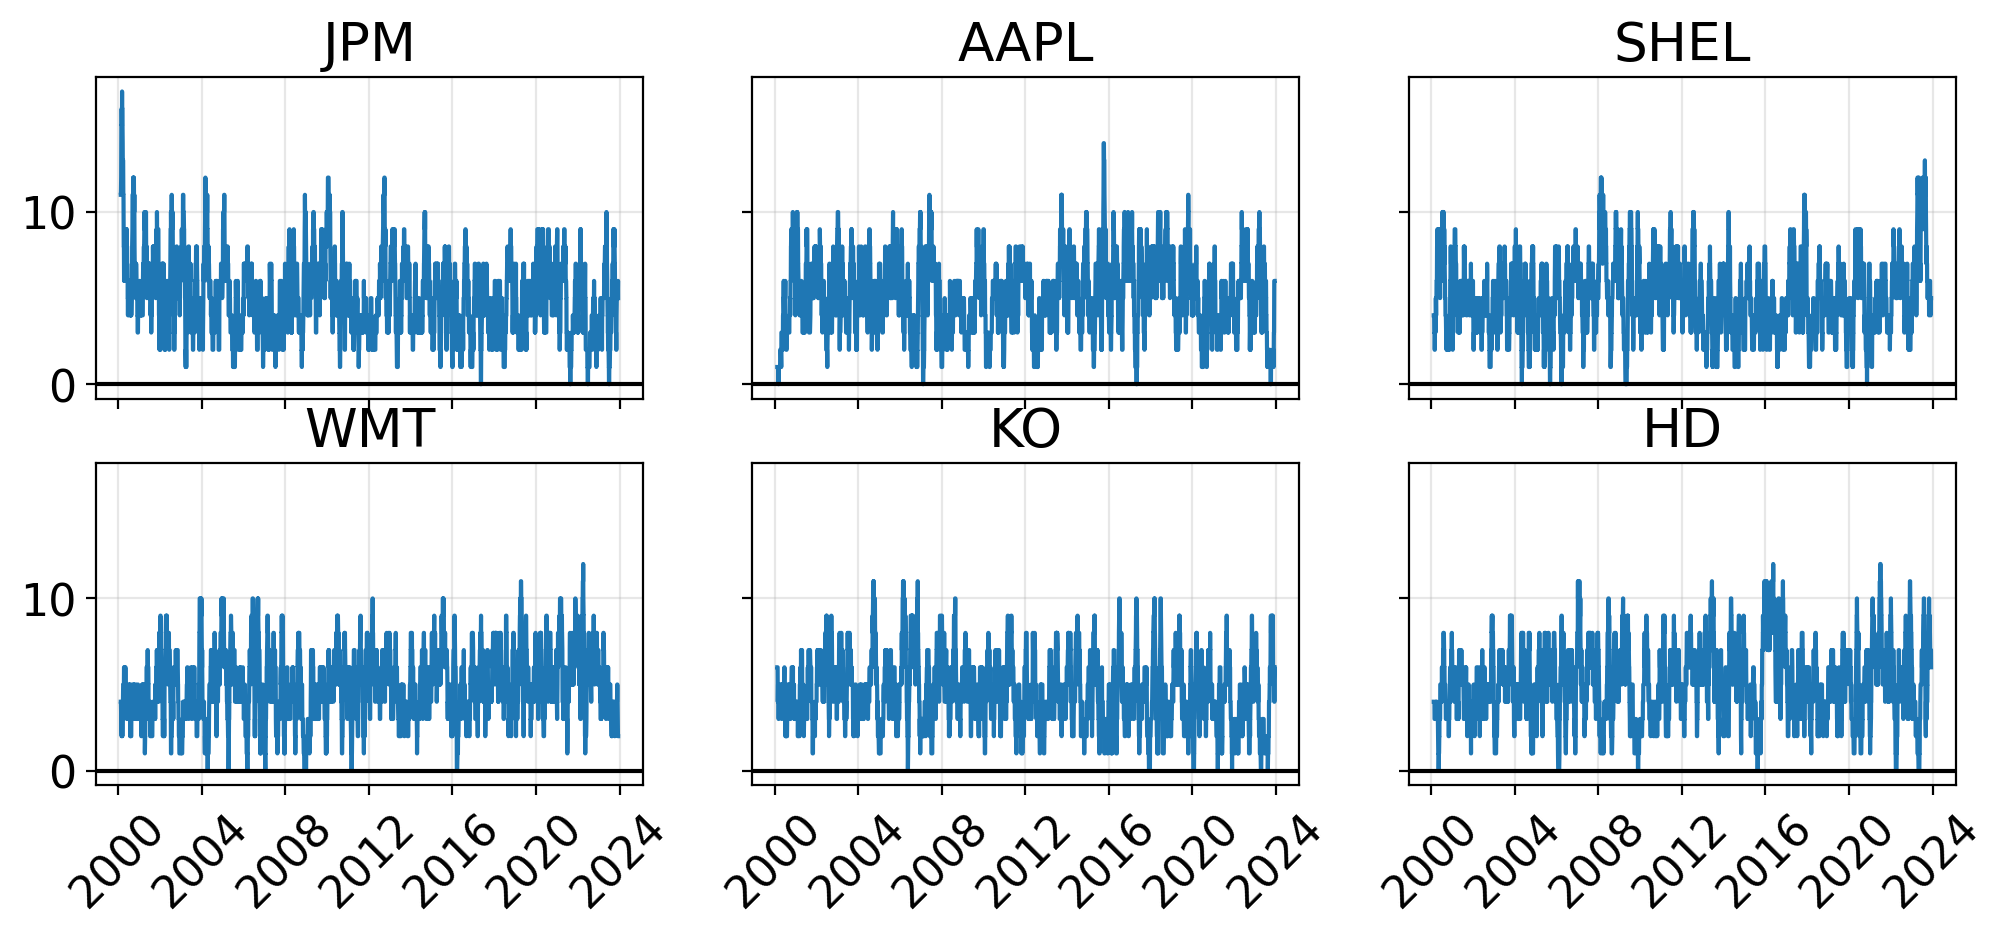

In [287]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 4.6))
ax = ax.ravel()
v = pd.DataFrame(actions_ohe, index=datasets.index[2:]).rolling(30).sum()
for i, axi in enumerate(ax):
    axi.set_title(assets[i])
    axi.plot(v[i])
    axi.axhline(y=0, c="black")
    axi.grid(alpha=0.3)
    plt.sca(axi)
    plt.xticks(rotation=45)

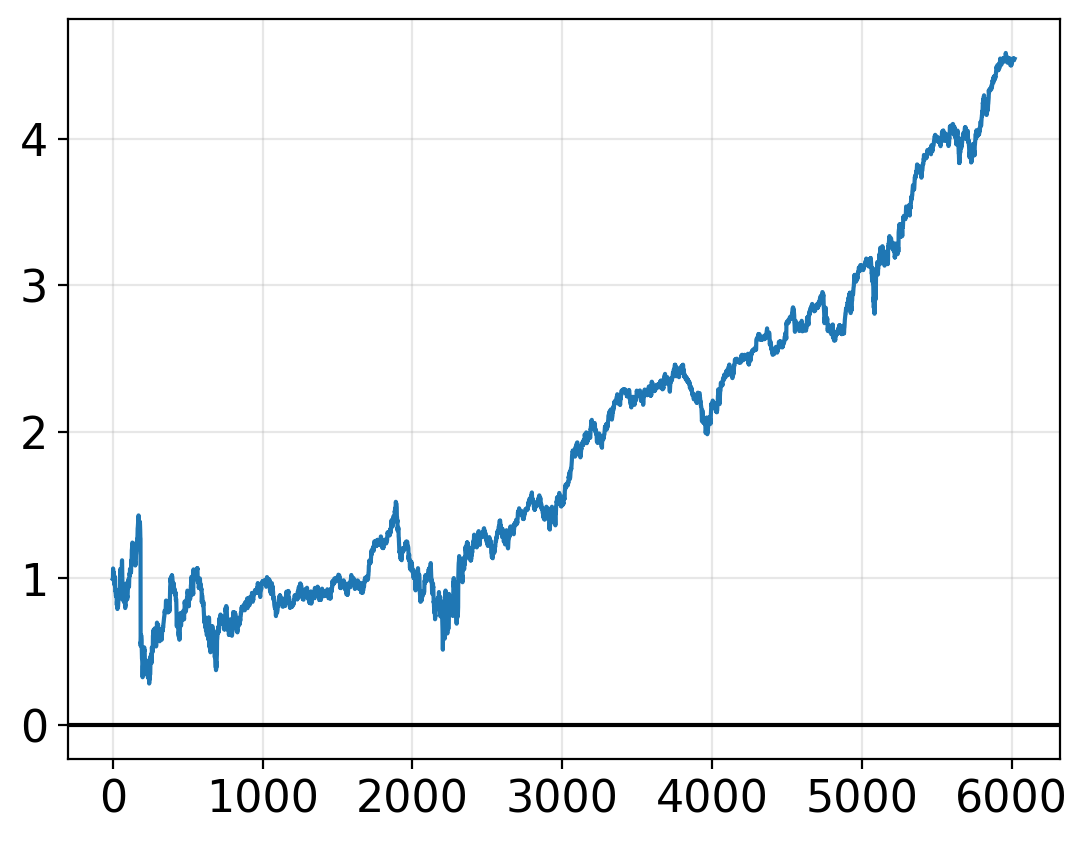

In [288]:
plt.plot(res.cumsum() + 1)
plt.grid(alpha=0.3)
plt.axhline(y=0, c="black")